In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
43702,NaN,NaN,International,2020-09-12,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43703,NaN,NaN,International,2020-09-13,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43704,NaN,NaN,International,2020-09-14,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


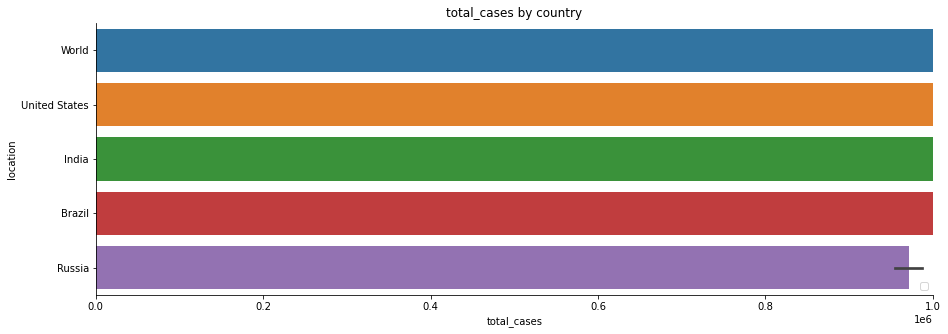

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


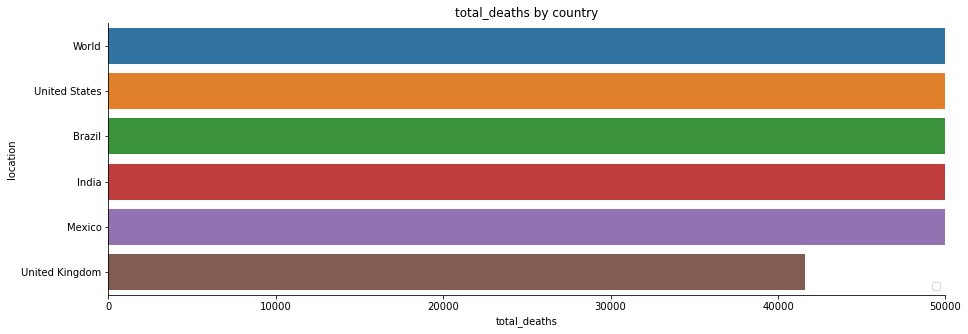

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


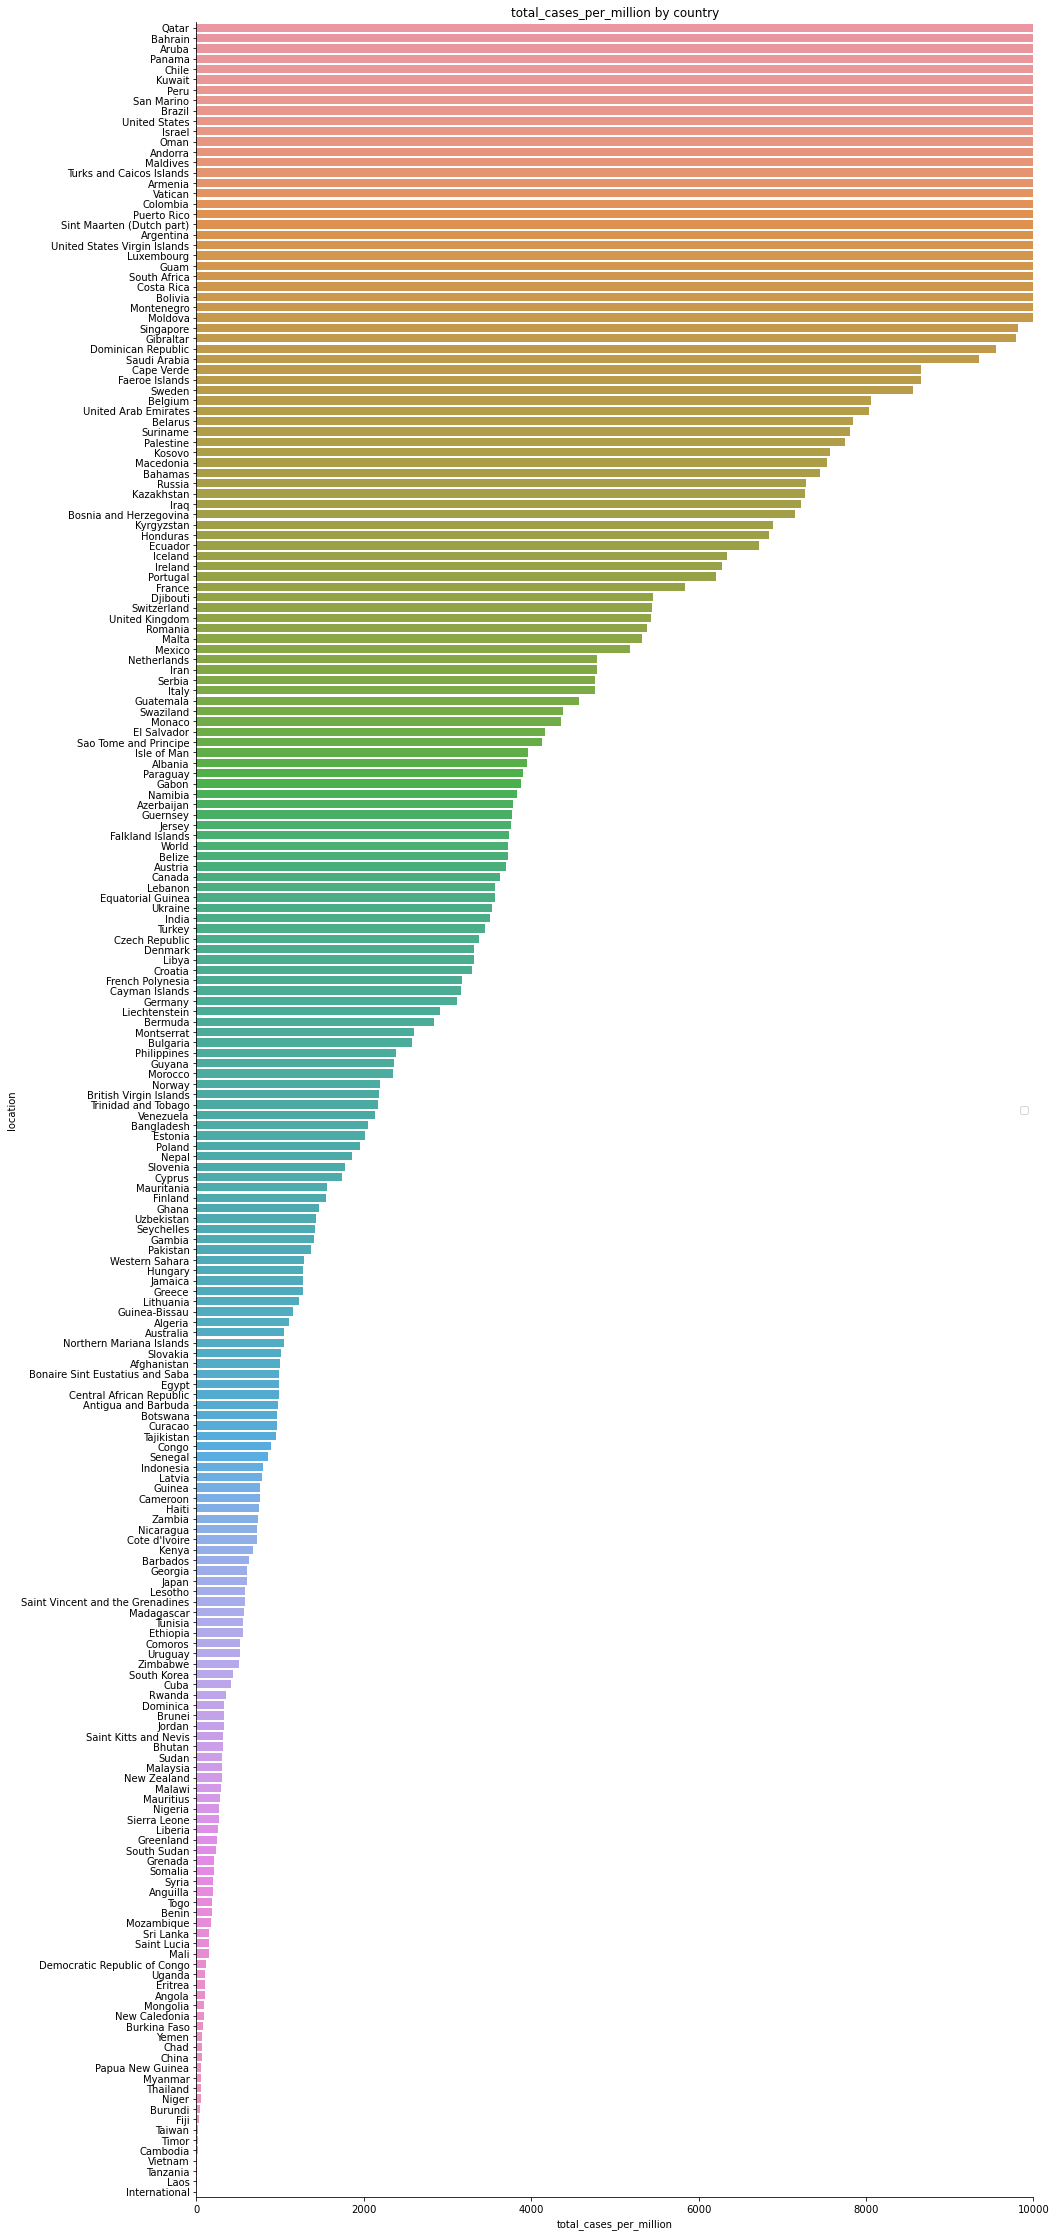

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


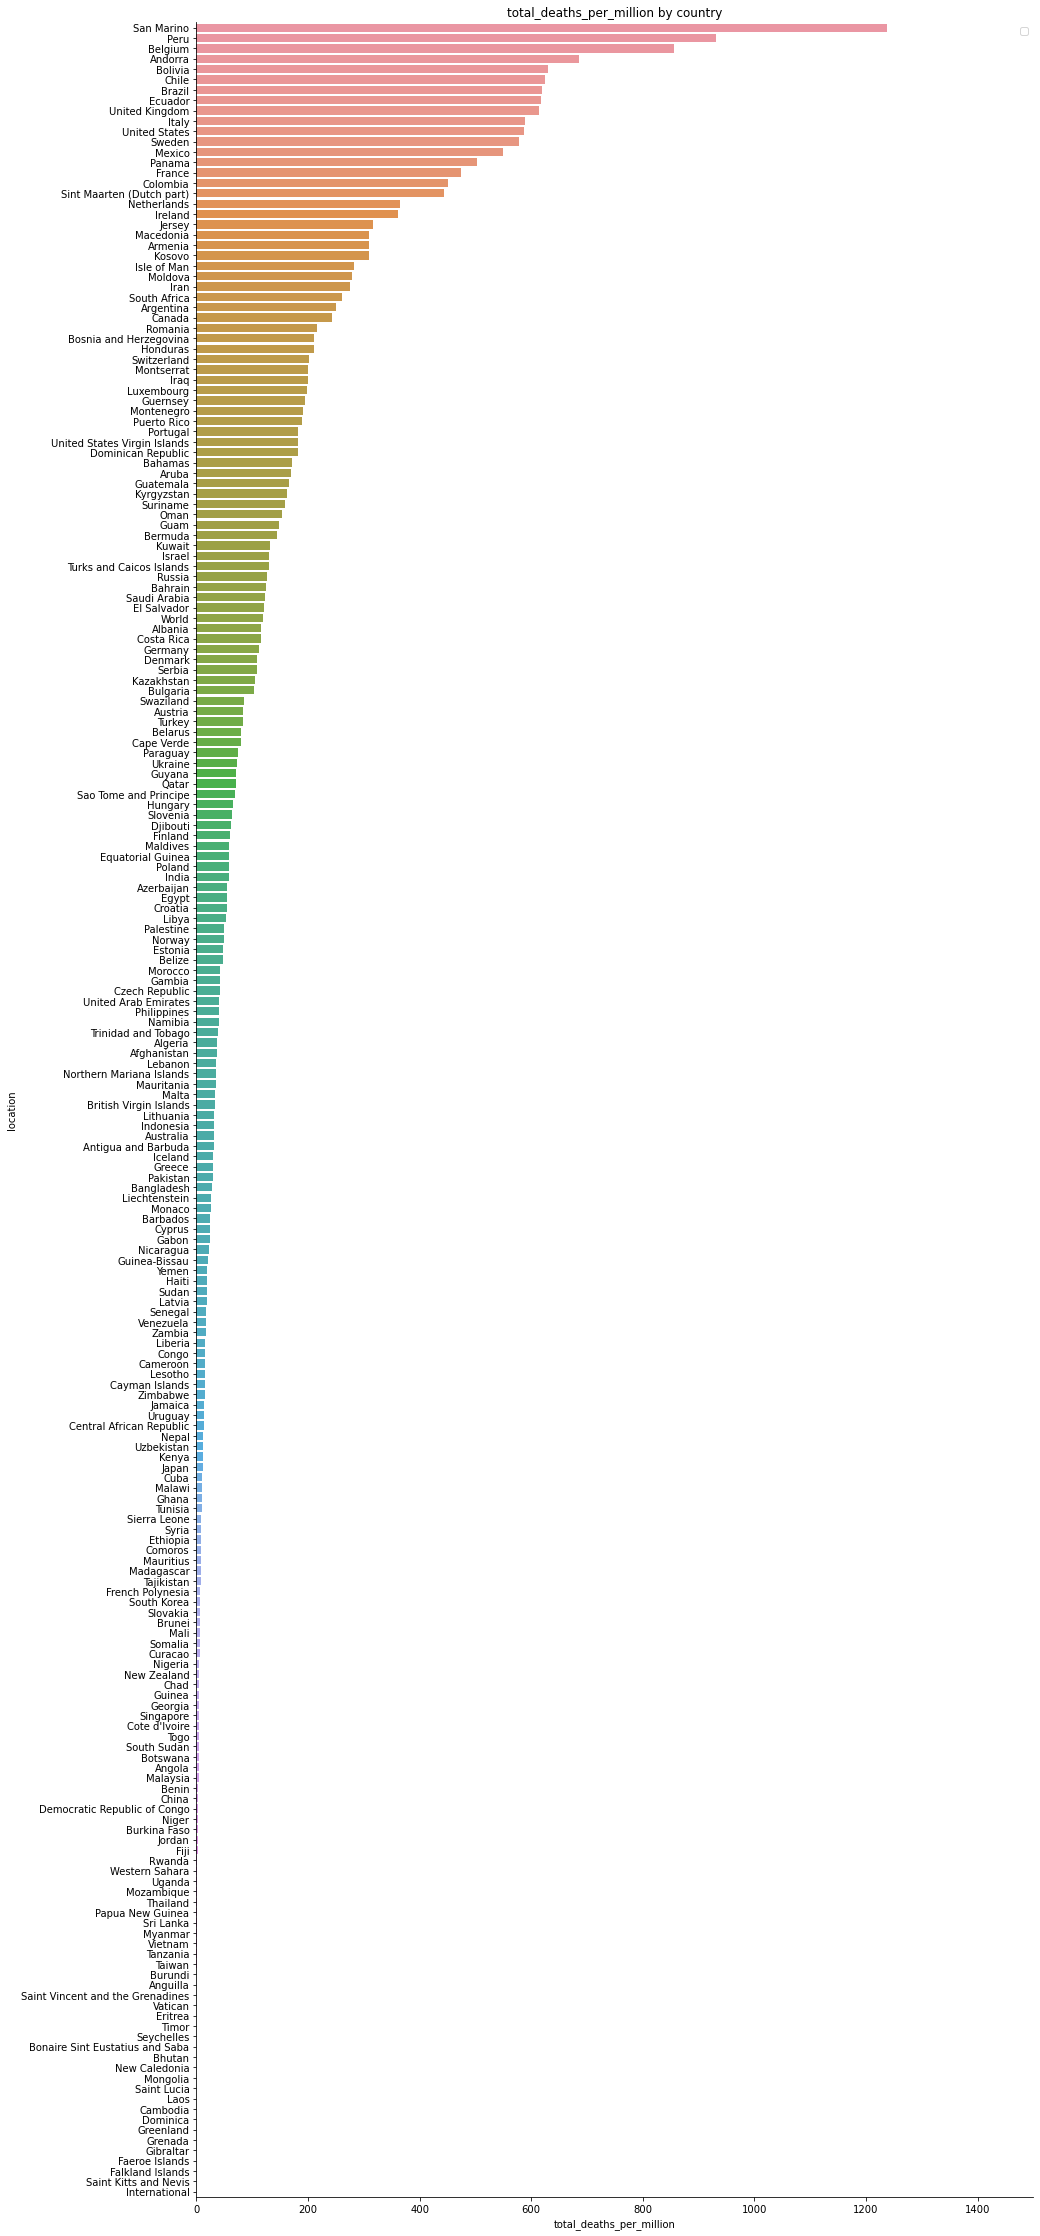

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

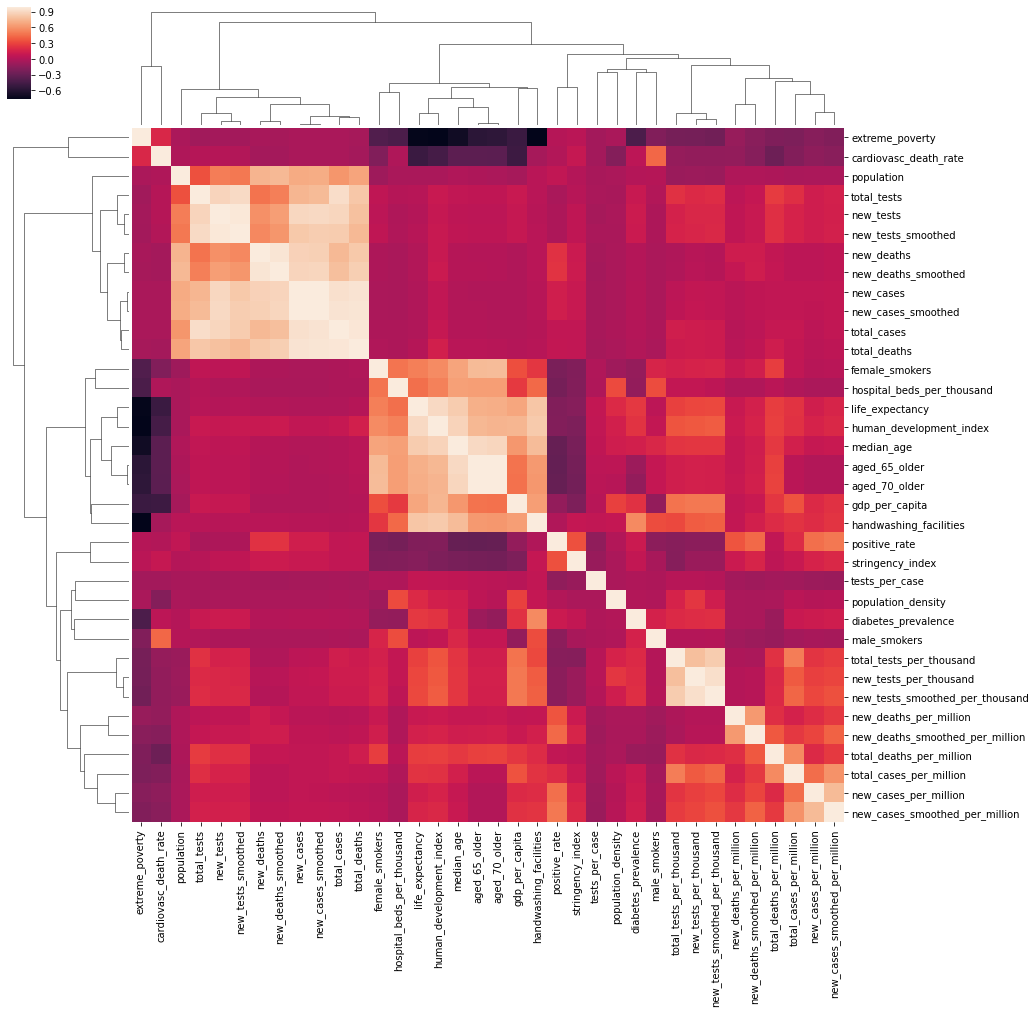

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9988809790879052 (+/- 0.0013084197068382337)
Coef :  [1.03341187e+00 8.88161579e-05 9.18389977e-05]
3 Last_days :  [[28518593 28804993 29049134]]
Today :  29049134
Prediction + :  524159
Tomorow :  29573293
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996501453271494 (+/- 0.0001060844182562258)
Coef :  [0.16459885 0.41022185 0.43544973]
3 Last_days :  [[916010 920937 924706]]
Today :  924706
Prediction + :  9570
Tomorow :  934276
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8714912720057343 (+/- 0.17789822281531253)
Coef :  [-0.75950401  0.78869478  0.97473271]
3 Last_days :  [[363350 373911 381094]]
Today :  381094
Prediction + :  9318
Tomorow :  390412
                                     
--------- Total Death -----------------
                                     
R^2: 0.8081081124612739 (+/- 0.2610984261105182)
Coef :  [-0.7490283   0.78852585  0.95947074]
3 Last_days :  [[30893 30910 30916]]
Today :  30916
Prediction + :  33
Tomorow :  30949
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9438938978383025 (+/- 0.05003037045046007)
Coef :  [-0.32812344 -0.01361378  1.3360032 ]
3 Last_days :  [[90145 90168 90197]]
Today :  90197
Prediction + :  28
Tomorow :  90225
                                     
--------- Total Death -----------------
                                     
R^2: -96.4160555440606 (+/- 137.66163647488347)
Coef :  [-0.07739553  0.0124662   1.05670987]
3 Last_days :  [[4733 4734 4734]]
Today :  4734
Prediction + :  5
Tomorow :  4739
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9550778912582693 (+/- 0.06240452634619812)
Coef :  [-0.81804479  0.89544046  0.9219876 ]
3 Last_days :  [[284796 286297 287753]]
Today :  287753
Prediction + :  1332
Tomorow :  289085
                                     
--------- Total Death -----------------
                                     
R^2: 0.6600173722721029 (+/- 0.45753870493516363)
Coef :  [-0.82323711  0.89697906  0.92529733]
3 Last_days :  [[35597 35603 35610]]
Today :  35610
Prediction + :  25
Tomorow :  35635
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.587781350137259 (+/- 0.5747382358588656)
Coef :  [-0.37492315  0.20718144  1.17162115]
3 Last_days :  [[566326 566326 566326]]
Today :  566326
Prediction + :  2510
Tomorow :  568836
                                     
--------- Total Death -----------------
                                     
R^2: 0.11231081867377642 (+/- 0.9556819537491106)
Coef :  [-0.72956338  0.63764093  1.09089557]
3 Last_days :  [[29747 29747 29747]]
Today :  29747
Prediction + :  7
Tomorow :  29754
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9777502617913066 (+/- 0.030627624721556508)
Coef :  [0.08230576 0.46172981 0.46915192]
3 Last_days :  [[6445288 6486108 6519979]]
Today :  6519979
Prediction + :  80601
Tomorow :  6600580
                                     
--------- Total Death -----------------
                                     
R^2: 0.9965897773632282 (+/- 0.0035415664524394365)
Coef :  [-0.45055844  0.69210056  0.76115631]
3 Last_days :  [[193016 193701 194079]]
Today :  194079
Prediction + :  1141
Tomorow :  195220
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9209882473273807 (+/- 0.11072398396088881)
Coef :  [-0.69063705  0.83291134  0.85832226]
3 Last_days :  [[361677 365174 368504]]
Today :  368504
Prediction + :  2730
Tomorow :  371234
                                     
--------- Total Death -----------------
                                     
R^2: 0.3116850479501136 (+/- 0.9308177732371975)
Coef :  [-0.76716075  0.83076009  0.93569617]
3 Last_days :  [[41614 41623 41628]]
Today :  41628
Prediction + :  41
Tomorow :  41669
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8799107411003079 (+/- 0.1687145315606966)
Coef :  [-0.7846128   0.85240965  0.93196076]
3 Last_days :  [[258480 259428 260355]]
Today :  260355
Prediction + :  941
Tomorow :  261296
                                     
--------- Total Death -----------------
                                     
R^2: 0.32149030835871845 (+/- 0.9496667948009645)
Coef :  [-0.78669053  0.83982948  0.94609549]
3 Last_days :  [[9347 9349 9350]]
Today :  9350
Prediction + :  7
Tomorow :  9357
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -5.947776829688739 (+/- 9.823785321173363)
Coef :  [0.28382976 0.36458937 0.36219234]
3 Last_days :  [[397801 399940 402029]]
Today :  402029
Prediction + :  3844
Tomorow :  405873
                                     
--------- Total Death -----------------
                                     
R^2: 0.9614843653568164 (+/- 0.0538936437494066)
Coef :  [0.07241816 0.47365324 0.46466676]
3 Last_days :  [[22913 23029 23157]]
Today :  23157
Prediction + :  234
Tomorow :  23391
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996308554113499 (+/- 0.00029473263461865247)
Coef :  [-0.67509683  0.82079666  0.85166547]
3 Last_days :  [[288126 289635 291162]]
Today :  291162
Prediction + :  1225
Tomorow :  292387
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994607174574327 (+/- 0.0003215977741909917)
Coef :  [-0.81204149  0.89443444  0.91534829]
3 Last_days :  [[6951 6999 7056]]
Today :  7056
Prediction + :  38
Tomorow :  7094
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6068626545698935 (+/- 0.5502983392943185)
Coef :  [-0.14222953  0.51418732  0.64139851]
3 Last_days :  [[4282164 4315687 4330455]]
Today :  4330455
Prediction + :  64752
Tomorow :  4395207
                                     
--------- Total Death -----------------
                                     
R^2: 0.47592742833409934 (+/- 0.7354881986480358)
Coef :  [-0.06962383  0.5031522   0.5774311 ]
3 Last_days :  [[130396 131210 131625]]
Today :  131625
Prediction + :  1627
Tomorow :  133252
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(29049134, 924706, 29573293, 934276),
 (381094, 30916, 390412, 30949),
 (287753, 35610, 289085, 35635),
 (566326, 29747, 568836, 29754),
 (6519979, 194079, 6600580, 195220),
 (90197, 4734, 90225, 4739),
 (368504, 41628, 371234, 41669),
 (260355, 9350, 261296, 9357),
 (402029, 23157, 405873, 23391),
 (291162, 7056, 292387, 7094),
 (4330455, 131625, 4395207, 133252)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-14,France,390412.0,0.0,30949.0,0.0,0.0,0.0
0,2020-09-14,China,90225.0,0.0,4739.0,0.0,0.0,0.0
0,2020-09-14,Italy,289085.0,0.0,35635.0,0.0,0.0,0.0
0,2020-09-14,Spain,568836.0,0.0,29754.0,0.0,0.0,0.0
0,2020-09-14,United States,6600580.0,0.0,195220.0,0.0,0.0,0.0
0,2020-09-14,World,29573293.0,0.0,934276.0,0.0,0.0,0.0
0,2020-09-14,United Kingdom,371234.0,0.0,41669.0,0.0,0.0,0.0
0,2020-09-14,Germany,261296.0,0.0,9357.0,0.0,0.0,0.0
0,2020-09-14,Iran,405873.0,0.0,23391.0,0.0,0.0,0.0
0,2020-09-14,Turkey,292387.0,0.0,7094.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")